In [6]:
import os
import wandb
import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms
from torchinfo import summary

BASE_PATH = str(os.path.curdir)  # BASE_PATH: /Users/yhhan/git/link_dl
print(BASE_PATH)

.


## 문제 1
#### Fashion MNIST 데이터 정규화를 위한 Mean과 Std. 값 찾기

In [7]:
data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

num_data_loading_workers = 0

train_data_loader = DataLoader(
    dataset=f_mnist_train, batch_size=999999, shuffle=True,
    pin_memory=True, num_workers=num_data_loading_workers
)

total_train_dataset = next(iter(train_data_loader))[0]

"""
문제 1. Fashion MNIST 데이터 정규화를 위한 Mean과 Std. 값 찾기
"""
print(total_train_dataset.shape)
print(f'mean : {total_train_dataset.mean()}')
print(f'std : {total_train_dataset.std()}')

torch.Size([55000, 1, 28, 28])
mean : 0.28637078404426575
std : 0.3531397879123688


In [8]:
def get_fashion_mnist_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    print("Num Train Samples: ", len(f_mnist_train))
    print("Num Validation Samples: ", len(f_mnist_validation))
    print("Sample Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])

    num_data_loading_workers = 0#get_num_cpu_cores() if is_linux() or is_windows() else 0
    print("Number of Data Loading Workers:", num_data_loading_workers)

    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers, drop_last=True
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=1,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.286, std=0.353),
    )

    return train_data_loader, validation_data_loader, f_mnist_transforms


def get_fashion_mnist_test_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

    print("Num Test Samples: ", len(f_mnist_test))
    print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=1)

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.286, std=0.353),
    )

    return f_mnist_test_images, test_data_loader, f_mnist_transforms

## 문제 2
#### Fashion MNIST 데이터에 대하여 CNN 학습시키기
##### lr=7e-2, activate_func='LeakyReLU', optim='SGD', BatchSize=128, Epochs=20

In [9]:
# 3x3, 5x5, 7x7 conv 레이어 중 2개와 입력 feature를 concated하고 채널을 맞추기 위해 1x1 conv를 통과시킨 입력 피처를 더함으로써 모델 구성
class MyModel(nn.Module):
    def __init__(self, in_channels, n_output, transform = None, middle_linear = 512):
        super().__init__()

        self.transform = transform

        current_in_channels = in_channels
        layers = []
        i = 0
        for val in wandb.config.feature_layers:
            remain = val - current_in_channels
            out1 = remain // 3
            out2 = out1 * 2
            conv33 = nn.Conv2d(in_channels=current_in_channels, out_channels=out2, kernel_size=(3, 3), stride=1, padding='same')
            convs55 = nn.Conv2d(in_channels=current_in_channels, out_channels=out2, kernel_size=(5, 5), stride=1, padding='same')
            conv55 = nn.Conv2d(in_channels=current_in_channels, out_channels=out1, kernel_size=(5, 5), stride=1, padding='same')
            conv77 = nn.Conv2d(in_channels=current_in_channels, out_channels=out1, kernel_size=(7, 7), stride=1, padding='same')
            
            if i % 3 == 0:
                layers.append(BranchConv(conv33, conv55, current_in_channels, val))
                layers.append(nn.LeakyReLU(negative_slope=0.01))
            elif i % 3 == 1:
                layers.append(BranchConv(conv33, conv77, current_in_channels, val))
                layers.append(nn.LeakyReLU(negative_slope=0.01))
            else:
                layers.append(BranchConv(convs55, conv77, current_in_channels, val))
                layers.append(nn.LeakyReLU(negative_slope=0.01))
                layers.append(nn.MaxPool2d(kernel_size=(2, 2)))
            
            current_in_channels = val

            layers.append(nn.BatchNorm2d(num_features=current_in_channels))

            i += 1

        self.model = nn.Sequential(
            nn.Sequential(*layers),
            nn.Flatten(),
            nn.Linear(current_in_channels * (28*28)//(4**(len(wandb.config.feature_layers)//3)), middle_linear),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm1d(middle_linear),
            nn.Linear(middle_linear, n_output),
        )

    def forward(self, x):
        if self.transform:
            x = self.transform(x)
        
        x = self.model(x)
        return x
    
class BranchConv(nn.Module):
    def __init__(self, conv1, conv2, in_channel, val):
        super(BranchConv, self).__init__()
        self.conv1 = conv1
        self.conv2 = conv2
        self.resconv = nn.Conv2d(in_channels=in_channel, out_channels=val, kernel_size=(1, 1), stride=1, padding='same')
    
    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(x)
        concat = torch.cat((x, out1, out2), dim=1)
        x = self.resconv(x)

        return concat + x

In [8]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /home/cuj/.netrc


True

In [12]:
do_eval = True
config = {'batch_size': 128, 'learning_rate': 7e-2, 'epochs': 20, 'feature_layers':[49, 73, 85, 181, 229, 253]}
wandb.init(project='homework_3 CNN', config=config)

train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data()
f_mnist_test_images, test_data_loader, f_mnist_transforms = get_fashion_mnist_test_data()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MyModel(in_channels=1, n_output=10, transform=f_mnist_transforms, middle_linear=512)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=wandb.config.learning_rate)
loss_fn = nn.CrossEntropyLoss()

# Training 시작
for epoch in range(config['epochs']):
    # Training
    correct = 0
    sumloss = 0
    total = 0
    model.train()
    pbar = tqdm.tqdm(train_data_loader, desc=f"Training Epoch {epoch + 1}/{config['epochs']}")
    for data, targets in pbar:
        outputs = model(data.to(device))
        loss = loss_fn(outputs, targets.to(device))
        _, predicted = outputs.max(1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        correct += (predicted.detach().cpu() == targets).sum().item()
        sumloss += loss.item()
        total += wandb.config.batch_size
        accuracy = correct / total

        pbar.set_postfix({"Loss": f"{sumloss / total:.4f}"})
    wandb.log({
        "Training Loss": sumloss / total,
        "Training Accuracy": accuracy * 100
    })

    if not do_eval: continue
    # Evaluate
    correct = 0
    sumloss = 0
    total = 0
    with torch.no_grad():
        model.eval()
        pbar = tqdm.tqdm(validation_data_loader, desc=f"Evaluation Epoch {epoch + 1}/{config['epochs']}")
        for data, targets in pbar:
            outputs = model(data.to(device))
            loss = loss_fn(outputs, targets.to(device))
            _, predicted = outputs.max(1)

            correct += (predicted.detach().cpu() == targets).sum().item()
            sumloss += loss.item()
            total += 1
            accuracy = correct / total

            pbar.set_postfix({"Accuracy": f"{accuracy * 100:.2f}%"})
        wandb.log({
            "Validation Loss": sumloss / total,
            "Validation Accuracy": accuracy * 100
        })
wandb.finish()

Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 0
Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])


Evaluation Epoch 20/20: 100%|██████████| 5000/5000 [00:11<00:00, 419.27it/s, Accuracy=94.20%]


Training Accuracy,▁▄▅▆▇▇██████████████
Training Loss,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▅▅▆▆▅▆▇▇███████████
Validation Loss,▆▁▁▁▃▆▆▅▇▆▆▆▇▇▇▇▇███
Training Accuracy,100
Training Loss,0.0
Validation Accuracy,94.2
Validation Loss,0.28317


In [15]:
# torchinfo 모듈을 사용한 모델 구조 출력
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 1, 28, 28]            --
│    └─ConvertImageDtype: 2-1            [1, 1, 28, 28]            --
│    └─Normalize: 2-2                    [1, 1, 28, 28]            --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Sequential: 2-3                   [1, 253, 7, 7]            --
│    │    └─BranchConv: 3-1              [1, 49, 28, 28]           834
│    │    └─LeakyReLU: 3-2               [1, 49, 28, 28]           --
│    │    └─BatchNorm2d: 3-3             [1, 49, 28, 28]           98
│    │    └─BranchConv: 3-4              [1, 73, 28, 28]           29,938
│    │    └─LeakyReLU: 3-5               [1, 73, 28, 28]           --
│    │    └─BatchNorm2d: 3-6             [1, 73, 28, 28]           146
│    │    └─BranchConv: 3-7              [1, 85, 28, 28]           35,210
│    

## 문제 3
#### 학습 완료된 모델로 테스트 데이터 Accuracy 확인하기

In [16]:
#Testing
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    pbar = tqdm.tqdm(test_data_loader, desc=f"Testing Epoch 1/1")
    for data, targets in pbar:
        outputs = model(data.to(device))
        _, predicted = outputs.max(1)

        correct += (predicted.detach().cpu() == targets).sum().item()
        total += targets.size(0)
        accuracy = correct / total
        
        pbar.set_postfix({"Accuracy": f"{accuracy * 100:.2f}%"})

Testing Epoch 1/1: 100%|██████████| 10000/10000 [00:22<00:00, 451.40it/s, Accuracy=93.61%]


## 문제 4
#### 샘플 테스트 데이터 분류 예측 결과 확인하기

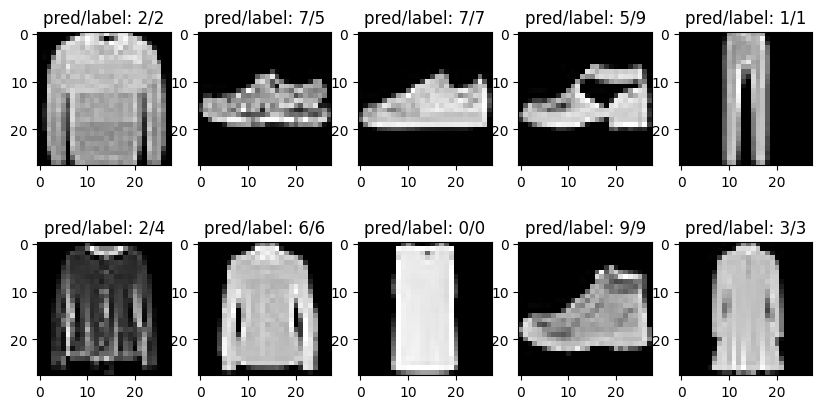

In [21]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# ne는 사진 넘기는 역할
ne = 20
with torch.no_grad():
    test_iter = iter(test_data_loader)
    for j in range(ne):
        test_data = next(test_iter)

    for i in range(10):
        test_data = next(test_iter)

        outputs = model(test_data[0].to(device))
        _, pred = outputs.max(1)

        axes[i//5][i%5].imshow(test_data[0].squeeze().numpy(), cmap="gray")
        axes[i//5][i%5].set_title(f"pred/label: {pred.item()}/{test_data[1].item()}")  # 레이블 추가

2, 4번째 이미지(예측:7, 라벨:5/예측:5, 라벨:9)를 통해 샌들, 부츠, 운동화 라벨 간의 분류를 진행하는 데 어려움이 있음을 확인할 수 있었습니다.\
또한 라운드티(2)와 코트(4) 간의 분류를 진행하는 데도 어려움이 있음을 확인할 수 있었는데,\
모델이 분류에 실패하는 이유는 이미지의 크기가 작고, 채널 또한 한개 밖에 없어 모델이 학습하는 데 어려움을 겪는 것 같다고 느꼈으며\
이는 실제로 사람이 육안으로 분류하기에 힘든 이미지에 속한다는 것을 알 수 있었습니다.

## 숙제 후기
이번 과제를 통해서 L2Norm, data_argumentation 등 모델의 성능을 높일 수 있는 여러 방법에 대해서 응용해봄으로써\
직접 성능 향상을 확인해볼 수 있는 기회를 가질 수 있었습니다.\
정확도 93 이상을 달성하기 위해 CNN 모델의 입력 피처의 수를 변경해보기도 했고, 옵티마이저의 learning_rate 값을 변경해보기도 했으며,\
activate_func을 고치거나 Convolution 연산 이후에 Drop_out을 적용시켜 보기도 하고 Convolution의 커널 사이즈 수 자체를 변경해보는 등\
여러 방법을 동원하여 간신히 넘길 수 있었던 것 같습니다.